In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import copy

In [2]:
import numpy as np
import cv2
import time
import json

def get_grid_cell_by_location(grid_dict,x,y):
    # This function returns a particular node given its x and y coordinates.

    grid_cell = None
    for loc in grid_dict["node_list"]:
        if loc["x"] == x and loc["y"] == y:
            grid_cell = loc
    return grid_cell

def create_grid_dict_from_array(grid_array):
    # This function converts the numpy array to a dict with information on
    # the number of columns, the number of rows, the start location, and the
    # goal and obstacle status of each cell, as well as possible actions in each cell.

    grid_dict = {}
    grid_dict["num_rows"] = len(grid_array[:,0])
    grid_dict["num_cols"] = len(grid_array[0,:])
    for i in range(len(grid_array[0,:])):
        for j in range(len(grid_array[:,0])):
            if grid_array[i,j] == 5:
                start_x = j
                start_y = i
    grid_dict["start_location"] = {
        "x": start_x,
        "y": start_y
    }
    grid_dict["node_list"] = []
    for i in range(len(grid_array[0,:])):
        for j in range(len(grid_array[:,0])):
            cost = 1
            if np.isnan(grid_array[i,j]):
                wall = True
                cost = np.nan
            else:
                wall = False
            if grid_array[i,j] == 1:
                goal = True
                cost = 0
            else:
                goal = False
            node = {
                "x": j,
                "y": i,
                "cost": cost,
                "goal": goal,
                "wall": wall
            }
            grid_dict["node_list"].append(node)

    for node in grid_dict["node_list"]:
        if node["wall"] == True:
            possible_actions = []
            node["possible_actions"] = possible_actions
            continue
        possible_actions = ["left","right","up","down"]
        x_location = node["x"]
        y_location = node["y"]
        if x_location-1 < 0:
            possible_actions.remove("left")
        else:
            if np.isnan(grid_array[y_location,x_location-1]):
                possible_actions.remove("left")
        if x_location+1 >= len(grid_array[0,:]):
            possible_actions.remove("right")
        else:
            if np.isnan(grid_array[y_location,x_location+1]):
                possible_actions.remove("right")
        if y_location-1 < 0:
            possible_actions.remove("up")
        else:
            if np.isnan(grid_array[y_location-1,x_location]):
                possible_actions.remove("up")
        if y_location+1 >= len(grid_array[:,0]):
            possible_actions.remove("down")
        else:
            if np.isnan(grid_array[y_location+1,x_location]):
                possible_actions.remove("down")
        node["possible_actions"] = possible_actions
        
    out_file = open("grid.json", "w")

    json.dump(grid_dict, out_file, indent = 4)

    out_file.close()
    return grid_dict

def plot_grid(grid_dict,grid):
    # This function plots the grid.

    cell_height = 300
    cell_width = 300
    top_left = (int(cell_height * 0.01), int(cell_width * 0.01))
    bot_right = (int(cell_height * 0.99), int(cell_width * 0.99))
    new_pos = (int(0.5 * cell_width), int(0.5 * cell_height))

    row_concatenation = None
    for row_ind in range(grid_dict["num_rows"]):
        column_concatenation = None

        for col_ind in range(grid_dict["num_cols"]):

            blank_image = np.ones((cell_height, cell_width, 3), np.uint8)
            colored_field = False
            # walls or special states or none
            if np.isnan(grid[row_ind,col_ind]):
                blank_image = blank_image * 128
                blank_image.astype(np.uint8)
            else:
                # white state by default
                blank_image = blank_image * 255
                blank_image = blank_image.astype(np.uint8)

            if grid[row_ind,col_ind] == 5:
                # start percept has border with special color
                txt_size = 2
                txt_color = (170, 255, 255)
                cv2.putText(blank_image, "start", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (170, 255, 255), int(cell_width * 0.06))
            elif grid[row_ind,col_ind] == 1:
                cost = 1

                if cost > 0:
                    rew_color = (86, 255, 170)
                else:
                    rew_color = (86, 86, 255)

                cv2.rectangle(blank_image, top_left, bot_right, rew_color, int(cell_width * 0.06))

                blank_image = blank_image.astype(np.uint8)

                if colored_field is True:
                    txt_color = (255, 255, 255)
                else:
                    txt_color = rew_color

                if abs(cost) > 9:
                    txt_size = 1
                else:
                    txt_size = 2

                cv2.putText(blank_image, "goal", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
            else:
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            blank_image = blank_image.astype(np.uint8)

            if column_concatenation is None:
                column_concatenation = blank_image
            else:
                column_concatenation = np.concatenate((column_concatenation, blank_image), axis=1)

        if row_concatenation is None:
            row_concatenation = column_concatenation
        else:
            row_concatenation = np.concatenate((row_concatenation, column_concatenation), axis=0)

    cv2.imwrite('grid.png', row_concatenation)

def plot_path(grid_dict,grid,move_sequence):
    # This function plots the grid and the path given in move_sequence. 
    # It also evaluates move_sequence to check for validity.

    curr_location = [grid_dict["start_location"]["x"],grid_dict["start_location"]["y"]]
    i = 0
    path_locations = []
    path_locations.append([curr_location[0],curr_location[1],i])
    for move in move_sequence:
        print(curr_location)
        curr_cell = get_grid_cell_by_location(grid_dict,curr_location[0],curr_location[1])
        print(curr_cell)
        if move not in curr_cell["possible_actions"]:
            print("Illegal move. Path is invalid")
            return
        else:
            if move == "left":
                curr_location = [curr_location[0]-1,curr_location[1]]
            elif move == "right":
                curr_location = [curr_location[0]+1,curr_location[1]]
            elif move == "up":
                curr_location = [curr_location[0],curr_location[1]-1]
            elif move == "down":
                curr_location = [curr_location[0],curr_location[1]+1]
            else:
                print("Move not supported. Path is invalid.")
                return
            i = i+1
            path_locations.append([curr_location[0],curr_location[1],i])
    print(path_locations)
        
    cell_height = 300
    cell_width = 300
    top_left = (int(cell_height * 0.01), int(cell_width * 0.01))
    bot_right = (int(cell_height * 0.99), int(cell_width * 0.99))
    new_pos = (int(0.5 * cell_width), int(0.5 * cell_height))

    row_concatenation = None
    for row_ind in range(grid_dict["num_rows"]):
        column_concatenation = None

        for col_ind in range(grid_dict["num_cols"]):

            blank_image = np.ones((cell_height, cell_width, 3), np.uint8)
            colored_field = False
            # walls or special states or none
            path_ind = None
            on_path = False
            for path_loc in path_locations:
                if path_loc[0] == col_ind and path_loc[1] == row_ind:
                    path_ind = path_loc[2]
                    on_path = True
            if np.isnan(grid[row_ind,col_ind]):
                blank_image = blank_image * 128
                blank_image.astype(np.uint8)
            elif on_path:
                blank_image[:,:,0] = 255
                blank_image[:,:,1] = 0
                blank_image[:,:,2] = 255
                # purple?
            else:
                # white state by default
                blank_image = blank_image * 255
                blank_image = blank_image.astype(np.uint8)


            if grid[row_ind,col_ind] == 5:
                # start percept has border with special color
                txt_size = 2
                txt_color = (170, 255, 255)
                cv2.putText(blank_image, "start", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (170, 255, 255), int(cell_width * 0.06))

            elif grid[row_ind,col_ind] == 1:
                cost = 1

                if cost > 0:
                    rew_color = (86, 255, 170)
                else:
                    rew_color = (86, 86, 255)

                cv2.rectangle(blank_image, top_left, bot_right, rew_color, int(cell_width * 0.06))

                blank_image = blank_image.astype(np.uint8)

                if colored_field is True:
                    txt_color = (255, 255, 255)
                else:
                    txt_color = rew_color

                if abs(cost) > 9:
                    txt_size = 1
                else:
                    txt_size = 2

                cv2.putText(blank_image, "goal", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
            elif on_path:
                txt_size = 1
                txt_color = (0,0,0)
                cv2.putText(blank_image, str(path_ind), new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            else:
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            blank_image = blank_image.astype(np.uint8)

            if column_concatenation is None:
                column_concatenation = blank_image
            else:
                column_concatenation = np.concatenate((column_concatenation, blank_image), axis=1)

        if row_concatenation is None:
            row_concatenation = column_concatenation
        else:
            row_concatenation = np.concatenate((row_concatenation, column_concatenation), axis=0)

    cv2.imwrite('path.png', row_concatenation)


# These are the two pre-defined grids.
grid1 = np.array([[ 1,  1,  1, 0,  1,  1,],
 [ 1,  1,  1,  5,  1,  1,],
 [ 1,  1,  1,  1,  1,  1,],
 [ 1, 0, 0,  1,  1,  1,],
 [ 2, 0,  1, 0,  1,  1,],
 [ 1,  1,  1, 0,  1,  1,]])

grid2 = np.array([[ 1,  1,  1,  2,  1, 0,],
 [ 1,  1,  1,  1,  1,  1,],
 [ 1, 0,  1,  1,  1,  1,],
 [ 1, 0,  1,  1,  1,  1,],
 [ 1, 0, 0,  1, 0,  1,],
 [ 1,  5,  1,  1,  1,  1,]])


# This block creates a 100x100 random grid, with 100 walls
random_grid = np.ones((10,10))
walls = np.random.choice(random_grid.size, 20, replace=False)
goals = np.random.choice(random_grid.size, 1, replace=False)
start = np.random.choice(random_grid.size, 1, replace=False)
random_grid.ravel()[walls] = 0
random_grid.ravel()[goals] = 2
random_grid.ravel()[start] = 5

print(random_grid)
grid = random_grid # or grid 2 or random_grid

grid_dict = create_grid_dict_from_array(grid)

# Comment out the plotting utilities for large grids.
# plot_grid(grid_dict,grid)

start = time.time()
### REPLACE BELOW CODE WITH YOUR ALGORITHMS ###
move_sequence = ["right","down","left","left","left","left","down","down"]
### REPLACE ABOVE CODE WITH YOUR ALGORITHMS ###
end = time.time()
print("Runtime: "+str(end-start))

#plot_path(grid_dict,grid,move_sequence

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 5. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
 [2. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]]
Runtime: 3.0279159545898438e-05


In [3]:
st_node_1 = []
end_node_1 = []
for i in range(len(grid1)):
    for j in range(len(grid1)):
        if np.isnan(grid1[i][j]):
            grid1[i][j] = 1
        elif grid1[i][j] == 5:
            st_node_1.append((i,j))
            grid1[i][j] =1
        elif grid1[i][j] == 2:
            end_node_1.append((i,j))
            grid1[i][j] =1
            
        
grid1 = [[int(x) for x in row] for row in grid1]

In [4]:
st_node_2 = []
end_node_2 = []
for i in range(len(grid1)):
    for j in range(len(grid2)):
        if np.isnan(grid2[i][j]):
            grid2[i][j] = 1
        elif grid2[i][j] == 5:
            st_node_2.append((i,j))
            grid2[i][j] =1
        elif grid2[i][j] == 2:
            end_node_2.append((i,j))
            grid2[i][j] =1
            
        
grid2 = [[int(x) for x in row] for row in grid2]

In [5]:
st_node = []
end_node = []
for i in range(len(grid)):
    for j in range(len(grid)):
        if np.isnan(grid[i][j]):
            grid[i][j] = 1
        elif grid[i][j] == 5:
            st_node.append((i,j))
            grid[i][j] =1
        elif grid[i][j] == 2:
            end_node.append((i,j))
            grid[i][j] =1
            
        
grid = [[int(x) for x in row] for row in grid]

A Star

In [6]:
class Node_star:
    def __init__ (self, r, c, val):
        self.id = str(r) + str(c)
        self.r = r
        self.c = c
        self.val = val
        self.g = float('inf')
        self.h = 0
        self.f = float('inf') 
        self.cameFrom = None

In [7]:
def initializeNodes(graph) :
    nodes = []
                                       
    for i, row in enumerate(graph) :
        nodes.append([])
        for j, value in enumerate(row) :
            nodes[i].append(Node_star(i, j, value))
    
    return nodes

In [8]:
def reconstructPath(goalNode):
    if not goalNode.cameFrom:
        return []

    currentNode = goalNode
    path = []

    while currentNode:
        path.append([currentNode.r, currentNode.c])
        currentNode = currentNode.cameFrom
       
    return path[::-1]

In [9]:
def heuristics(currentNode,goalNode,heur):
    currentRow = currentNode.r
    currentCol = currentNode.c
    goalRow = goalNode.r
    goalCol = goalNode.c
    
    if heur == 'Manhattan':
        Manhattan_distance = abs(currentRow - goalRow) + abs (currentCol - goalCol)
        return Manhattan_distance

In [10]:
def getNeighboringNodes (node, nodes):
    neighbors = []

    numRows = len(nodes)
    numCols = len(nodes[0])
    
    
    row = node.r
    col = node.c
    
    if row < numRows - 1: # DOWN
        neighbors.append(nodes[row + 1][col])
                                       
    if row > 0: # UP
        neighbors.append(nodes[row - 1][col])
                                       
    if col < numCols - 1: # RIGHT
        neighbors.append(nodes[row][col + 1])
                                       
    if col > 0: # LEFT
        neighbors.append(nodes[row][col - 1])
        
    return neighbors

In [11]:
from typing import List


class MinHeap:
    def __init__(self, listP):
        # Holds the position in the heap that each node is at
        self.nodePositionsInHeap = {node.id: idx for idx, node in enumerate (listP)}
        self.heap = self.buildHeap(listP)
    
    def isEmpty(self):
        return len(self.heap) == 0
    
    # O(n) time 0(1) space
    def buildHeap(self, listP) :
        ParentoneIndex = (len (listP) - 2) // 2
        for curr_Index in reversed (range (ParentoneIndex + 1)):
            self.shiftDown (curr_Index, len(listP)- 1, listP)
        return listP
                                       
    def shiftDown(self, curr_Index, endIdx, heap) :
        leftchild_Index = curr_Index * 2 + 1
        while leftchild_Index <= endIdx:
            rightchild_Index = curr_Index * 2 + 2 if curr_Index * 2 + 2 <= endIdx else -1
            if rightchild_Index!=-1 and heap[rightchild_Index].f < heap[leftchild_Index].f:
                idxToSwap = rightchild_Index
            else:
                idxToSwap = leftchild_Index
            if heap[idxToSwap].f<heap[curr_Index].f:
                self.swap(curr_Index, idxToSwap, heap)
                curr_Index = idxToSwap
                leftchild_Index = curr_Index * 2 + 1
            elif heap[idxToSwap].g>heap[curr_Index].g and heap[idxToSwap].f ==heap[curr_Index].f :
                self.swap(curr_Index, idxToSwap, heap)
                curr_Index= idxToSwap
                leftchild_Index = curr_Index * 2 + 1
            else:
                return
                                       
    def shiftUp(self, curr_Index, heap):
        parentIdx = (curr_Index - 1) // 2
        while curr_Index > 0:
          if heap[curr_Index].f < heap[parentIdx].f:
            self.swap(curr_Index, parentIdx, heap)
            curr_Index = parentIdx
            parentIdx = (curr_Index - 1) // 2
          elif heap[curr_Index].f == heap[parentIdx].f and heap[curr_Index].g >heap[parentIdx].g:
              self.swap(curr_Index, parentIdx, heap)
              curr_Index = parentIdx
              parentIdx = (curr_Index - 1) // 2
          else:
            curr_Index = parentIdx
            parentIdx = (curr_Index - 1) // 2
    
    def remove(self):
        self.swap(0,len(self.heap)-1,self.heap)
        node = self.heap.pop()
        del self.nodePositionsInHeap[node.id]
        self.shiftDown(0,len(self.heap)-1,self.heap)
        return node
                                       
    def insert(self, node):
        self.heap.append(node)
        self.nodePositionsInHeap[node.id] = len(self.heap) - 1
        self.shiftUp(len(self.heap) - 1, self.heap)

    def swap(self, i, j, heap) :
        self.nodePositionsInHeap[heap[i].id] = j
        self.nodePositionsInHeap[heap[j].id]=i
        heap[i], heap[j] = heap[j], heap[i]
        
    def containsNode(self, node) :
        return node.id in self.nodePositionsInHeap
    
    def update(self, node):
        self.shiftUp(self.nodePositionsInHeap[node.id],self.heap)

In [12]:
from typing import List


class MinHeap:
    def __init__(self, listP):
        # Holds the position in the heap that each node is at
        self.nodePositionsInHeap = {node.id: idx for idx, node in enumerate (listP)}
        self.heap = self.buildHeap(listP)
    
    def isEmpty(self):
        return len(self.heap) == 0
    
    # O(n) time 0(1) space
    def buildHeap(self, listP) :
        ParentoneIndex = (len (listP) - 2) // 2
        for curr_Index in reversed (range (ParentoneIndex + 1)):
            self.shiftDown (curr_Index, len(listP)- 1, listP)
        return listP
                                       
    def shiftDown(self, curr_Index, endIdx, heap) :
        leftchild_Index = curr_Index * 2 + 1
        while leftchild_Index <= endIdx:
            rightchild_Index = curr_Index * 2 + 2 if curr_Index * 2 + 2 <= endIdx else -1
            if rightchild_Index!=-1 and heap[rightchild_Index].f < heap[leftchild_Index].f:
                idxToSwap = rightchild_Index
            else:
                idxToSwap = leftchild_Index
            if heap[idxToSwap].f<heap[curr_Index].f:
                self.swap(curr_Index, idxToSwap, heap)
                curr_Index = idxToSwap
                leftchild_Index = curr_Index * 2 + 1
            elif heap[idxToSwap].g>heap[curr_Index].g and heap[idxToSwap].f ==heap[curr_Index].f :
                self.swap(curr_Index, idxToSwap, heap)
                curr_Index= idxToSwap
                leftchild_Index = curr_Index * 2 + 1
            else:
                return
                                       
    def shiftUp(self, curr_Index, heap):
        parentIdx = (curr_Index - 1) // 2
        while curr_Index > 0:
          if heap[curr_Index].f < heap[parentIdx].f:
            self.swap(curr_Index, parentIdx, heap)
            curr_Index = parentIdx
            parentIdx = (curr_Index - 1) // 2
          elif heap[curr_Index].f == heap[parentIdx].f and heap[curr_Index].g >heap[parentIdx].g:
              self.swap(curr_Index, parentIdx, heap)
              curr_Index = parentIdx
              parentIdx = (curr_Index - 1) // 2
          else:
            curr_Index = parentIdx
            parentIdx = (curr_Index - 1) // 2
    
    def remove(self):
        self.swap(0,len(self.heap)-1,self.heap)
        node = self.heap.pop()
        del self.nodePositionsInHeap[node.id]
        self.shiftDown(0,len(self.heap)-1,self.heap)
        return node
                                       
    def insert(self, node):
        self.heap.append(node)
        self.nodePositionsInHeap[node.id] = len(self.heap) - 1
        self.shiftUp(len(self.heap) - 1, self.heap)

    def swap(self, i, j, heap) :
        self.nodePositionsInHeap[heap[i].id] = j
        self.nodePositionsInHeap[heap[j].id]=i
        heap[i], heap[j] = heap[j], heap[i]
        
    def containsNode(self, node) :
        return node.id in self.nodePositionsInHeap
    
    def update(self, node):
        self.shiftUp(self.nodePositionsInHeap[node.id],self.heap)

In [13]:
def greedy_best(startRow, startCol, GoalRow, GoalCol, maze, heur) :
    
    nodes = initializeNodes(maze)
    startNode = nodes[startRow][startCol]
    goalNode = nodes[GoalRow][GoalCol]
    
    
    startNode.g = 0 
    startNode.h = heuristics(startNode,goalNode,heur)
    startNode.f = startNode.h
    
    nodesToVisit = MinHeap([startNode])
    visitedNode = []

    while not nodesToVisit.isEmpty():
        currentMinDistanceNode = nodesToVisit.remove()
        visitedNode.append([currentMinDistanceNode.r, currentMinDistanceNode.c])
        if currentMinDistanceNode == goalNode:
            break
            
        neighbors = getNeighboringNodes(currentMinDistanceNode, nodes)
        for neighbor in neighbors:
            if neighbor.val == 0:
                continue
                
            tenativeDistanceToNeighbor = currentMinDistanceNode.g + 1


            if tenativeDistanceToNeighbor >= neighbor.g:
                continue
            
            neighbor.cameFrom = currentMinDistanceNode
            neighbor.g = tenativeDistanceToNeighbor
            neighbor.f =  heuristics(neighbor,goalNode,heur)
        
            if not nodesToVisit.containsNode(neighbor) :
                nodesToVisit.insert(neighbor)
            else:
                nodesToVisit.update(neighbor)
                
    a =  reconstructPath(goalNode)
    return a,visitedNode

Runtime: 0.00013208389282226562
7


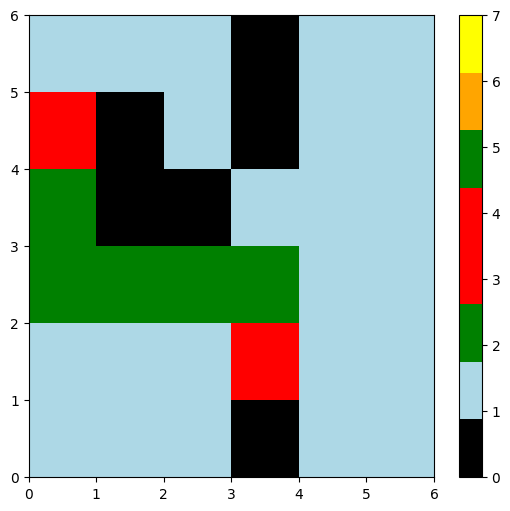

In [14]:
start = time.time()
a,a_vis = greedy_best(st_node_1[0][0],st_node_1[0][1],end_node_1[0][0],end_node_1[0][1],grid1,"Manhattan") #Forward A* - Manhattan
end = time.time()
print("Runtime: "+str(end-start))
print(len(a))

maze_forward = copy.copy(grid1)
    
# for z, row in enumerate(a_vis):
#     i = row[0]
#     j = row[1]
#     maze_forward[i][j] = 111
    
for z, row in enumerate(a):
    i = row[0]
    j = row[1]
    maze_forward[i][j] = 222
        
maze_forward[st_node_1[0][0]][st_node_1[0][1]]=888
maze_forward[end_node_1[0][0]][end_node_1[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111:2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)

Runtime: 0.00012993812561035156
8


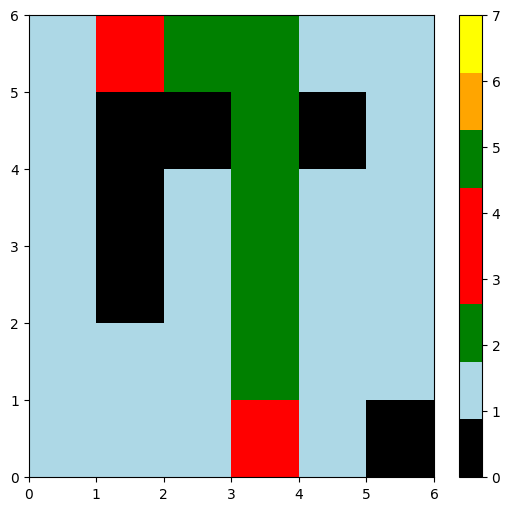

In [15]:
start = time.time()
b,b_vis = greedy_best(st_node_2[0][0],st_node_2[0][1],end_node_2[0][0],end_node_2[0][1],grid2,"Manhattan") #Forward A* - Manhattan
end = time.time()
print("Runtime: "+str(end-start))
print(len(b))

maze_forward = copy.copy(grid2)
    
# for z, row in enumerate(a_vis):
#     i = row[0]
#     j = row[1]
#     maze_forward[i][j] = 111
    
for z, row in enumerate(b):
    i = row[0]
    j = row[1]
    maze_forward[i][j] = 222
        
maze_forward[st_node_2[0][0]][st_node_2[0][1]]=888
maze_forward[end_node_2[0][0]][end_node_2[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111:2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)

Runtime: 0.0002968311309814453
8


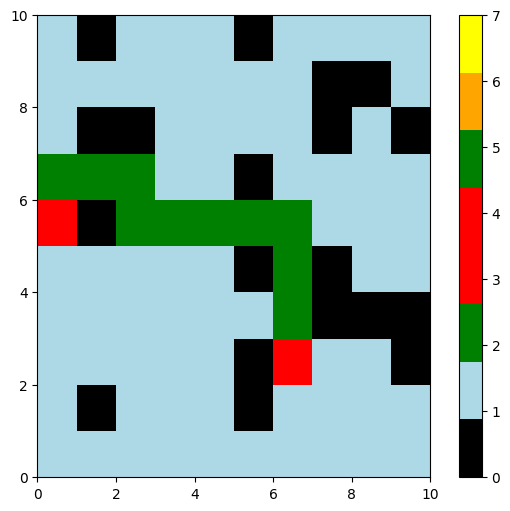

In [16]:
start = time.time()
c,c_vis = greedy_best(st_node[0][0],st_node[0][1],end_node[0][0],end_node[0][1],grid,"Manhattan") #Forward A* - Manhattan
end = time.time()
print("Runtime: "+str(end-start))
print(len(b))

maze_forward = copy.copy(grid)
    
# for z, row in enumerate(a_vis):
#     i = row[0]
#     j = row[1]
#     maze_forward[i][j] = 111
    
for z, row in enumerate(c):
    i = row[0]
    j = row[1]
    maze_forward[i][j] = 222
        
maze_forward[st_node[0][0]][st_node[0][1]]=888
maze_forward[end_node[0][0]][end_node[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111:2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)